In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import random
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, brier_score_loss, log_loss
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
import pickle

In [3]:
mem = Memory("./mycache")
PATH = "../data/"
learning_rate = 0.001

In [4]:
@mem.cache
def get_data(file_name):
    data = load_svmlight_file(file_name)
    print data[1].shape
    return zip(data[0][:data[0].shape[0]/10,:], np.array(map(lambda x: [0,1] if x == -1 else [1,0], data[1][:data[0].shape[0]/10]))), data[0].shape[1]

In [5]:
sess = tf.Session()

def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.scalar_summary('mean/' + name, mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
      tf.scalar_summary('sttdev/' + name, stddev)
      tf.scalar_summary('max/' + name, tf.reduce_max(var))
      tf.scalar_summary('min/' + name, tf.reduce_min(var))
      tf.histogram_summary(name, var)


def weight_variable(shape, name):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)


def bias_variable(shape, name):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)


def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.scalar_summary('sttdev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
 #       tf.histogram_summary(name, var)


def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read, and
    adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim], layer_name+"_weights")
            variable_summaries(weights, layer_name + '/weights')
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim], layer_name+"_biases")
            variable_summaries(biases, layer_name + '/biases')
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
#            tf.histogram_summary(layer_name + '/pre_activations', preactivate)
        activations = act(preactivate, 'activation')
#        tf.histogram_summary(layer_name + '/activations', activations)
        return activations

# Loading Data

In [6]:
print "loading train data"
train_x_y, feature_count = get_data(PATH + "a4_smvl_trn")
#print "read train: X:", train_X.shape,"y: ", train_y.shape

loading train data


In [7]:
print "loading test data"
test_x_y, _ = get_data(PATH+"a4_smvl_tst")
print "loading data finished"


loading test data
loading data finished


# Training Model

In [8]:
x_tensor = tf.placeholder("float", [None, feature_count])
y_tensor = tf.placeholder("float", [None, 2])

inter = nn_layer(x_tensor, feature_count, 50, 'layer1')
y = nn_layer(inter, 50, 2, 'layer2', act=tf.nn.softmax)

with tf.name_scope('cross_entropy'):
    diff = y_tensor * tf.log(y)
    with tf.name_scope('total'):
        cross_entropy = -tf.reduce_mean(diff)
        #cross_entropy = -tf.reduce_sum(y_tensor*tf.log(tf.clip_by_value(y,1e-10,1.0)))
    tf.scalar_summary('cross entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_tensor, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.scalar_summary('accuracy', accuracy)

In [ ]:
merged = tf.merge_all_summaries()
init = tf.initialize_all_variables()
sess.run(init)
train_writer = tf.train.SummaryWriter('/tmp/log', sess.graph)

batch_size = 100
counter = 0
saver = tf.train.Saver()
for epoch in range(25):
    random.shuffle(train_x_y)
    start = 0
    while start < len(train_x_y):
        batch = train_x_y[start:start+batch_size]
        start = start+batch_size
        labels = []
        feats_np = np.zeros((len(batch),feature_count))
        for i,f_l in enumerate(batch):
            feats,label  = f_l
            
            feats_np[i,:] = feats.todense()
            labels.append(label)
        labels_np = np.vstack(labels)
        feed_dict = {x_tensor:feats_np, y_tensor:labels_np}
        # print x_tensor,y_tensor,feats_np.shape,labels_np.shape
        summary,_ = sess.run([merged,train_step],feed_dict=feed_dict)
        train_writer.add_summary(summary, counter)
        counter += 1
        # prediction = sess.run(y,feed_dict=feed_dict)
        # print len(prediction)
    print epoch
    if epoch%10 == 0 and epoch>0:
        save_path = saver.save(sess, "/tmp/model_"+str(epoch)+".ckpt")
        print "save ", epoch, "th variables to ", save_path

# Model Evaluation

Calculating Probabilities

In [13]:
del train_x_y

In [ ]:
#test_x_y = np.array(test_x_y)
#test_X = test_x_y[0,:]
#probabilities=y
#probas = probabilities.eval(feed_dict=test_X, session=sess)
#print "probabilities", probas

In [46]:
probas, test_y = [], []

start = 0
batch_size = 100
while start < len(test_x_y):
    batch = test_x_y[start:start+batch_size]
    start = start+batch_size
    labels = []
    feats_np = np.zeros((len(batch),feature_count))
    for i,f_l in enumerate(batch):
        feats,label  = f_l
        feats_np[i,:] = feats.todense()
        labels.append(label)
    labels_np = np.vstack(labels)
    probas.append(y.eval(feed_dict={x_tensor:feats_np}, session=sess))
    test_y.append(labels_np)

In [49]:
probas = np.vstack(probas)
test_y = np.vstack(test_y)

In [56]:
probas[:,1].shape

(248011,)

ROC/AUC/bier

In [82]:
def plot_ROC(probs, test_y):
    print "plotting ROC"
    fpr, tpr, th = roc_curve(test_y, probs)
    print "compute AUC"
    auc_this = auc(fpr, tpr)
    plt.plot( fpr[:], tpr[:], color = 'r',linewidth=5.0, label = "AUC="+str(auc_this))
    plt.plot( [x /1000.0 for x in range(1000)], [x /1000.0 for x in range(1000)], 'b--',linewidth=2.0)
    plt.title("ROC_MLP")
    plt.legend()
    #print "testing finished"
    plt.show()
    print

In [79]:
lost = log_loss(test_y, probas)
print 'Lost', lost
print "Brier Score:", brier_score_loss(test_y[:,1], probas[:,1])

Lost 0.361089439128
Brier Score: 0.0713458523226


In [65]:
print len(test_y)

248011


plotting ROC
compute AUC


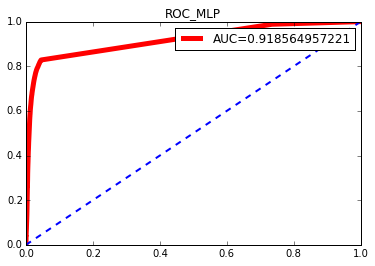

In [83]:
plot_ROC(probas[:,1], test_y[:,1])

# Appendix

In [ ]:
# Accuracy was not calculated due to memory limitations. And also because assignment did not ask for it

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_tensor, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print "Accuracy : ", accuracy.eval({x_tensor: test_X, y: test_y}, session=sess)


In [ ]:
test_X = []
for i, x_y in enumerate(test_x_y):
    test_X.append(x_y[0].eval())
test_X = np.array(test_X)
print test_X